# NEXUS tool: case study for the Souss-Massa basin - energy demand calculations
In this notebook a case study for the Souss-Massa basin is covered using the `nexus_tool` package. The water requirements for agricultural irrigation, residential, industrial and tourism use were previously calculated using the Water Evaluation and Planning System (WEAP) model. In this case study, the energy requirements for groundwater pumping, wastewater treatment, desalination of seawater and pumping for water conveyance are estimated.

First import the package by running the following block:

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import os
import nexus_tool
from nexus_tool.weap_tools import create_folder
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from pandas.plotting import register_matplotlib_converters
import plotly.express as px
# register_matplotlib_converters()

In [43]:
scenarios = ['Reference']
load_folder = os.path.join('Data - Souss-Massa', 'Merged data')
results_folder = os.path.join('Morocco dashboard', 'data')
create_folder(results_folder)
for scenario in scenarios:
    scenario_folder = os.path.join(load_folder, scenario)
    create_folder(os.path.join(results_folder, scenario))
    for sub_scenario in os.listdir(scenario_folder):
        sub_scenario_folder = os.path.join(scenario_folder, sub_scenario)
        create_folder(os.path.join(results_folder, scenario, sub_scenario))
        for level in os.listdir(sub_scenario_folder):
            output_folder = os.path.join(results_folder, scenario, sub_scenario, level)
            load_data = os.path.join(sub_scenario_folder, level)
            create_folder(output_folder)
            
            #Define the path to read the scenario input data and reads it in
            file_path = os.path.join(load_data, 'demand_data.csv')
            df = nexus_tool.read_csv(file_path)
            
            #Creates the nexus model with the input dataframe
            souss_massa = nexus_tool.Model(df)
            
            #Define the diameter of the pipelines. The first is general for all and the following specific for each case
            souss_massa.df['Pipe_diameter'] = 0.4
            souss_massa.df.loc[souss_massa.df['type'].str.contains('GW'), 'Pipe_diameter'] = 0.4
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Pipeline'), 'Pipe_diameter'] = 0.8
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), 'Pipe_diameter'] = 0.4
            
            #Define the variable to take into account for elevation difference and lenght of pipelines
            souss_massa.elevation = 'elevation_diff' #for the case of GW, the elevation_diff is set to be the wtd
            souss_massa.L = 'distance' #for the case of GW, the distance is set to be the wtd
            
            #Defines the name of the variable for Peak Water Demand and Seasonal Water demand (monthly)
            souss_massa.pwd = 'pwd'
            souss_massa.sswd = 'sswd'
            souss_massa.df.rename(columns={'value': 'sswd'}, inplace=True)
            souss_massa.peak_Q = souss_massa.pwd #This is a work around so we are able to calculat all energy demand with the SW_pumping method
            souss_massa.avg_Q = souss_massa.sswd #This is a work around so we are able to calculat all energy demand with the SW_pumping method
            souss_massa.swpp_e = 'swpp_e'
            souss_massa.pd_e = 'swpp_e'
            souss_massa.swpa_e = 'swpa_e'
            souss_massa.pumping_hours_per_day = 10
            souss_massa.SWpump_eff = 0.6
            
            #Defines the PWD. It is defined as double the seasonal demand for agricultural sites
            souss_massa.df[souss_massa.pwd] = souss_massa.df[souss_massa.sswd] / 3600 / 30 / souss_massa.pumping_hours_per_day #to convert to cubic meter per second [m3/s]
            souss_massa.df.loc[souss_massa.df['type']=='Agriculture', souss_massa.pwd] *= 2
            
            #Calculates some required parameters
            souss_massa.get_A(inplace=True)
            souss_massa.get_V(inplace=True, axis=0)
            souss_massa.get_Re(inplace=True, axis=0)
            souss_massa.get_f(inplace=True, axis=0)

            souss_massa.get_sw_tdh(inplace = True, axis=0) #this is called sw but it calculets for gw too. I still need to change the names
            souss_massa.get_SWpumping_energy(inplace = True, axis=0) #the same here
            
            souss_massa.df.loc[souss_massa.df.swpp_e<0, souss_massa.swpp_e] = 0
            souss_massa.df.loc[souss_massa.df.swpa_e<0, souss_massa.swpa_e] = 0
            
            #Define energy intensity for seawater desalination project
            desalination_energy_int = 3.31 # kWh/m3
            #We compute the energy demand for deslination multiplying the monthly water requirement by the energy intensity, 
            #and add it to the current energy requirements for desalinated water pumping
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.swpa_e] += \
                                    souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.sswd] * \
                                    desalination_energy_int
            #Then we divide the total energy requiered for desalination by the daily pumping hours and the days of the month
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.swpp_e] = \
                                    souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.swpa_e] / \
                                    souss_massa.pumping_hours_per_day / 30 #30 days per month

            #Here we load the WWTP inflow data
            file_path = os.path.join(load_data, 'wwtp_inflow.csv')
            df_wwtp = pd.read_csv(file_path)
            
            #We define an energy intensity for wastewater treatment and compute the energy demand
            wwtp_energy_int = 0.6 # kWh/m3
            df_wwtp['swpa_e'] = df_wwtp.value * wwtp_energy_int
            
            
            #From here onwards we calculate the LCOE method. It is working at the moment for 
            #the demand points of the schematic but I need to change it for the GIS cropland and built-up areas
            
            #Define the path to read the cropland and builtup are data and reads it in
            folder_path = os.path.join('Data - Souss-Massa', 'Cropland and Builtarea')
            cropland_path = os.path.join(folder_path, 'cropland.csv')
            cropland = nexus_tool.read_csv(cropland_path)
            builtareas_path = os.path.join(folder_path, 'builtarea.csv')
            builtareas = nexus_tool.read_csv(builtareas_path)
            
            summary_provinces_domestic = souss_massa.df.loc[souss_massa.df['type'].str.contains('Domestic')].groupby(['Province'])[['sswd', 'pwd', 'swpa_e', 'swpp_e']].sum()
            summary_provinces_agri = souss_massa.df.loc[souss_massa.df['type'].str.contains('Agriculture')].groupby(['Province'])[['sswd', 'pwd', 'swpa_e', 'swpp_e']].sum()
            temp_cropland_provinces = cropland.province.copy()
            temp_cropland_provinces.loc[temp_cropland_provinces=='Inezgane-Aït Melloul'] = 'Taroudannt'
            temp_builtareas_provinces = builtareas.province.copy()
            temp_builtareas_provinces.loc[temp_builtareas_provinces=='Inezgane-Aït Melloul'] = 'Agadir-Ida ou Tanane'
            for feature in list(summary_provinces_agri):
                cropland[feature] = temp_cropland_provinces.map(summary_provinces_agri[feature]) * cropland['area_share']
                builtareas[feature] = temp_builtareas_provinces.map(summary_provinces_domestic[feature]) * builtareas['area_share']
            
            sm_cropland = nexus_tool.Model(cropland)
            
            sm_cropland.start_year = 2018
            sm_cropland.end_year = 2050
            sm_cropland.discount_rate = 0.05
            sm_cropland.pwd = 'pwd'
            sm_cropland.sswd = 'sswd'
            sm_cropland.pd_e = 'swpp_e'
            sm_cropland.swpp_e = 'swpp_e'
            sm_cropland.swpa_e = 'swpa_e'
            
            sm_cropland.create_wind_turbine('Wind power', life=20,
                                            om_cost=0.02, capital_cost=1300,
                                            efficiency=0.6)
            
            sm_cropland.create_pv_system('Solar PV', life=15,
                                         om_cost=0.01, capital_cost=1140,
                                         efficiency=0.7)
            
#             sm_cropland.create_standard_tech('Diesel set', life=10, om_cost=0.1,
#                                              capital_cost=938, fuel_cost=0.3,
#                                              fuel_req=0.095, efficiency=0.27, cf = 0.5,
#                                              emission_factor=2.7, env_cost=0)
            
            sm_cropland.create_standard_tech('Grid pump', life=10, om_cost=0.1,
                                             capital_cost=845, fuel_cost=0.1,
                                             fuel_req=1, efficiency=0.55, cf = 0.8,
                                             emission_factor=0.728, env_cost=0)
            
#             np.random.seed(1)
#             souss_massa.df['wind'] = np.random.randint(5,15,souss_massa.df.shape[0])
#             souss_massa.df['srad'] = np.random.randint(22000,50000,souss_massa.df.shape[0])
            
            sm_cropland.get_cf('all', axis=0)
            sm_cropland.get_installed_capacity('all', axis=0)
            sm_cropland.get_max_capacity('a', axis=0)
            sm_cropland.get_lcoe(years='all', axis=0)
            
            sm_cropland.get_least_cost(technologies='a', years='all', axis=0)
            
            souss_massa.df.to_csv(os.path.join(output_folder, 'results.csv'), index=False)
            sm_cropland.lcoe.to_csv(os.path.join(output_folder, 'lcoe.csv'), index=False)
            df_wwtp.to_csv(os.path.join(output_folder, 'wwtp_data.csv'), index=False)

In [46]:
sm_cropland.df.head()

,Year,Demand point,province,area_m2,Month,srad,wind,area_share,sswd,pwd,swpa_e,swpp_e
0,2018,7579,Agadir-Ida ou Tanane,102166.996364,1,12350.049290,2.988044,0.000042,16315.244412,0.015107,0.0,0.0
1,2018,7580,Agadir-Ida ou Tanane,98718.747355,1,12269.503302,2.929310,0.000041,15764.586887,0.014597,0.0,0.0
2,2018,7581,Agadir-Ida ou Tanane,229879.711173,1,12268.392943,2.908396,0.000096,36709.933801,0.033991,0.0,0.0
3,2018,7582,Agadir-Ida ou Tanane,11281.955150,1,12389.000000,3.400000,0.000005,1801.637146,0.001668,0.0,0.0
4,2018,7583,Agadir-Ida ou Tanane,13997.885311,1,12447.000000,3.600000,0.000006,2235.349264,0.002070,0.0,0.0


In [45]:
souss_massa.df.head()

,Date,Supply point,Year,Month,links,sswd,Demand point,type,wtd,elevation_diff,...,distance,Pipe_diameter,pwd,Pipe_area,Flow_velocity_,Re_,f_,tdh_sw,swpp_e,swpa_e
0,2019-09-01,Desalination,2019,9,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,19230.740029,0.4,0.0,0.125664,0.0,0.0,0.0,10.0,0.0,0.0
1,2019-10-01,Desalination,2019,10,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,19230.740029,0.4,0.0,0.125664,0.0,0.0,0.0,10.0,0.0,0.0
2,2019-11-01,Desalination,2019,11,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,19230.740029,0.4,0.0,0.125664,0.0,0.0,0.0,10.0,0.0,0.0
3,2019-12-01,Desalination,2019,12,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,19230.740029,0.4,0.0,0.125664,0.0,0.0,0.0,10.0,0.0,0.0
4,2020-01-01,Desalination,2020,1,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,19230.740029,0.4,0.0,0.125664,0.0,0.0,0.0,10.0,0.0,0.0


In [47]:
year = 2020
water = souss_massa.df.loc[(souss_massa.df.Year==year)&(souss_massa.df['type'].str.contains('GW'))].sswd.sum()
energy = souss_massa.df.loc[(souss_massa.df.Year==year)&(souss_massa.df['type'].str.contains('GW'))].swpa_e.sum()

In [48]:
energy/water

3.6480172004382725

In [49]:
souss_massa.df.loc[(souss_massa.df.Year==2020)&(souss_massa.df.type.str.contains('Domestic'))].groupby(['Year','Demand point']).agg({'sswd': 'sum','swpa_e': 'sum', 'type': 'first'})

sswd         swpa_e         type
Year Demand point                                              
2020 AEP Rural         0.000000e+00       0.000000  GW Domestic
     AEP Taroudant     5.985467e+06  783725.145569  GW Domestic
     AEPR              2.737500e+01       5.581882  GW Domestic
     AEPR 2            2.737500e+01      10.204745  GW Domestic
     AEP_Aoulouz       4.104113e+05   57240.126795  GW Domestic
     AEP_Ighrem        1.743340e+05   78754.762072  GW Domestic
     AEP_SEl Guerdane  2.873562e+05       0.000000  SW Domestic
     AEP_Taliouine     6.065371e+05   84596.118157  GW Domestic
     AEP_ouled berhil  5.992730e+05   77891.801272  GW Domestic
     Agadir            4.634073e+07       0.000000  GW Domestic
     Ait Baha          1.815976e+05       0.000000  SW Domestic
     Biougra           4.278443e+06  950577.901441  GW Domestic
     Lakhssass         1.561740e+05       0.000000  SW Domestic
     Ouled Teima       5.099266e+06  666204.146945  GW Domestic
     Sidi Ifni         7.518153e+05       0.000000  GW Domestic
     Tafraout          1.852300e+05       0.000000  SW Domestic
     Tiznit            4.060531e+06       0.000000  SW Domestic

In [6]:
sm_cropland.technologies

{'Wind power': <nexus_tool.Model.WindTurbine at 0x239449109e8>,
 'Solar PV': <nexus_tool.Model.PVSystem at 0x239449109b0>,
 'Grid pump': <nexus_tool.Model.Technology at 0x23944910d30>}

### From here you will find some code to explore the LCOE results:

In [7]:
sm_cropland.lcoe.dropna()

water demand  required capacity  energy demand  \
Demand point Year                                                   
0            2018  3.519616e+04         242.729995   8.738280e+05   
             2019  3.519616e+04         242.729995   8.738280e+05   
             2020  3.519616e+04         242.729995   8.738280e+05   
             2021  3.519616e+04         242.729995   8.738280e+05   
             2022  3.519616e+04         242.729995   8.738280e+05   
...                         ...                ...            ...   
7712         2046  1.543205e+06      111952.785923   4.030300e+08   
             2047  1.543205e+06      111952.785923   4.030300e+08   
             2048  1.543205e+06      111952.785923   4.030300e+08   
             2049  1.543205e+06      111952.785923   4.030300e+08   
             2050  1.543205e+06      111952.785923   4.030300e+08   

                  least_cost_technology      lcoe  
Demand point Year                                  
0            2018             Grid pump  0.218153  
             2019             Grid pump  0.218091  
             2020             Grid pump  0.218006  
             2021             Grid pump  0.218103  
             2022             Grid pump  0.218185  
...                                 ...       ...  
7712         2046             Grid pump  0.219811  
             2047             Grid pump  0.219778  
             2048             Grid pump  0.219279  
             2049              Solar PV  0.212334  
             2050              Solar PV  0.158285  

[254529 rows x 5 columns]

### The following block creates a plot grid displaying a parameter for each demand point (with demand), the parameter can be `water demand`, `energy demand`, `lcoe` or `required capacity`
You can uncomment the `sharey=True` line, if you whant to see the same scale in the `y` axis for all of the plots.

In [125]:
dff = souss_massa.lcoe.reset_index().dropna().pivot('Year','Demand point','water demand')
amount = dff.columns.shape[0] + 1
dff.plot(subplots=True,
         layout=(int(amount/2), 2),
         figsize=(16,24),
#          sharey=True
        )

AttributeError: 'Model' object has no attribute 'lcoe'

In [50]:
sm_cropland.technologies['Solar PV'].lcoe

,Demand point,discounted_costs,discounted_generation,lcoe,year
0,0,36564.703622,1.656724e+05,0.220705,2018
1,1,243145.533808,1.112624e+06,0.218533,2018
2,2,548634.905311,2.558673e+06,0.214422,2018
3,3,96469.787021,4.475391e+05,0.215556,2018
4,4,72713.807827,3.310559e+05,0.219642,2018
...,...,...,...,...,...
254524,7708,11.400000,0.000000e+00,NaN,2050
254525,7709,11.400000,0.000000e+00,NaN,2050
254526,7710,11.400000,0.000000e+00,NaN,2050
254527,7711,11.400000,0.000000e+00,NaN,2050


In [51]:
df = sm_cropland.lcoe.dropna()
df.reset_index().pivot('Year','Demand point','least_cost_technology')

Demand point,0,1,2,3,4,5,6,7,8,9,...,7569,7570,7571,7572,7573,7574,7575,7576,7577,7578
Year,,,,,,,,,,,,,,,,,,,,,
2018,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2019,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2020,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2021,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2022,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2023,Solar PV,Grid pump,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2024,Solar PV,Grid pump,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2025,Solar PV,Grid pump,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2026,Solar PV,Grid pump,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV


In [52]:
sm_cropland.lcoe.head()

water demand  required capacity  energy demand  \
Demand point Year                                                   
0            2018  27328.869437           2.738855    9859.878989   
             2019  27328.869437           2.738855    9859.878989   
             2020  27328.869437           2.738855    9859.878989   
             2021  27328.869437           2.738855    9859.878989   
             2022  27328.869437           2.738855    9859.878989   

                  least_cost_technology      lcoe  
Demand point Year                                  
0            2018              Solar PV  0.220705  
             2019              Solar PV  0.220159  
             2020              Solar PV  0.219463  
             2021              Solar PV  0.220310  
             2022              Solar PV  0.221104

In [53]:
import geopandas as gpd

cropland = gpd.read_file(r"Data - Souss-Massa\GIS\Processed layers\cropland_2013_processed_20200218_clean.csv", encoding='utf-8')

In [59]:
df = sm_cropland.lcoe.reset_index()

df = df.loc[(df.Year==2020)]
df['geometry'] = df['Demand point'].map(cropland.geometry)
df = gpd.GeoDataFrame(df, crs='epsg:26192')
df.to_crs('epsg:4326', inplace=True)

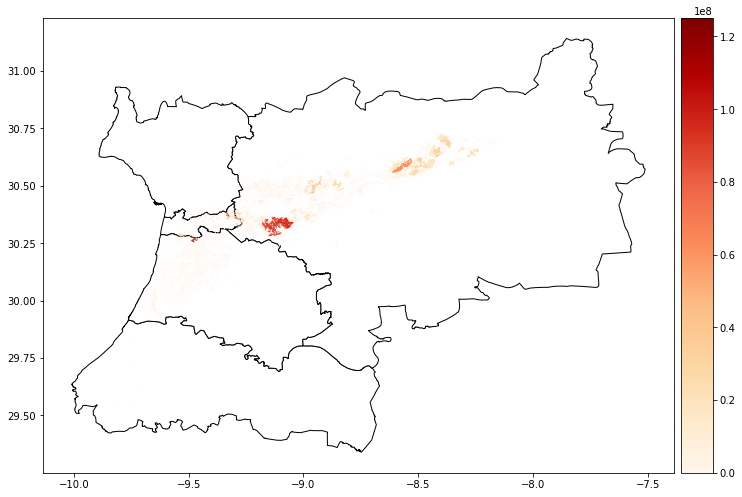

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

provinces = gpd.read_file('Data - Souss-Massa/GIS/Admin/Provinces.gpkg', encoding='utf-8')

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

provinces.plot(color='white', edgecolor='black', ax=ax)
df.plot(column='energy demand', ax=ax, cmap='OrRd', legend=True, cax=cax)

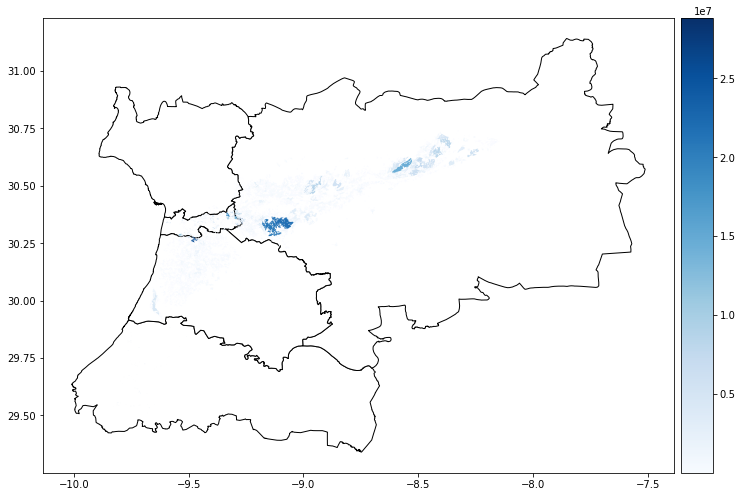

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

provinces.plot(color='white', edgecolor='black', ax=ax)
df.plot(column='water demand', ax=ax, cmap='Blues', legend=True, cax=cax)

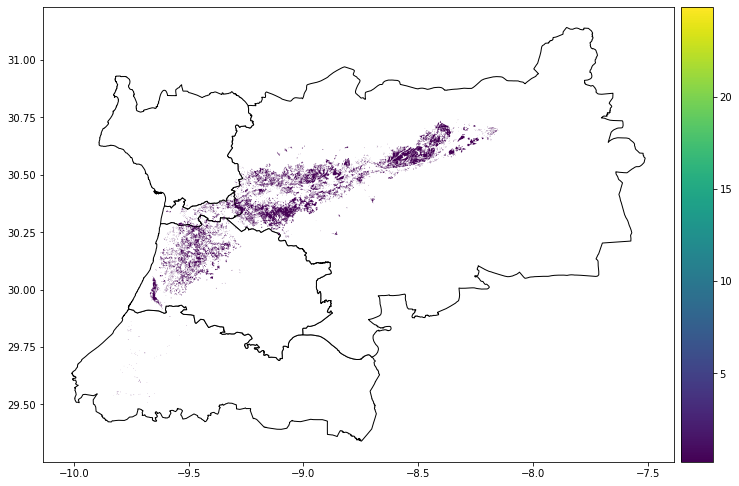

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

provinces.plot(color='white', edgecolor='black', ax=ax)
df.plot(column='lcoe', ax=ax, legend=True, cax=cax)

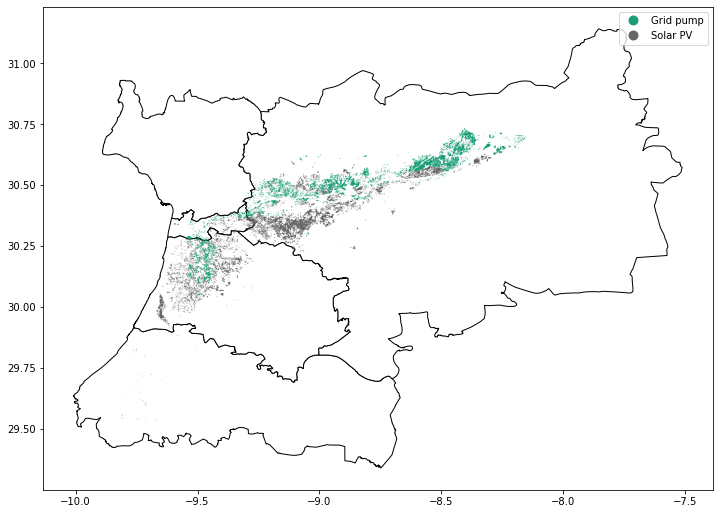

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

provinces.plot(color='white', edgecolor='black', ax=ax)
df.plot(column='least_cost_technology', categorical=True, cmap='Dark2', ax=ax, legend=True, cax=cax)